## **0. Getting setup**

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.4.0+cu121
torchvision version: 0.19.0+cu121


Now we'll continue with the regular imports, setting up device agnostic code and this time we'll also get the helper_functions.py script from GitHub.

The helper_functions.py script contains several functions we created in previous sections:

set_seeds() to set the random seeds (created in 07. PyTorch Experiment Tracking section 0).

download_data() to download a data source given a link (created in 07. PyTorch Experiment Tracking section 1).

plot_loss_curves() to inspect our model's training results (created in 04. PyTorch Custom Datasets section 7.8)

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## **1. Getting data**

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)


In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [ ]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## **2. FoodVision Mini model deployment experiment outline**

3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.
1. Performs well: 95%+ accuracy
2. Fast as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
* Latency = time for prediction to take place.
To try and achieve these goals, we're going to build two model experiments:
1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

## **3. Creating an EffNetB2 feature extractor**
Feature extractor = a term for transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem

EffNetB2 pretrained model in PyTorch: https://pytorch.org/vision/main/models/efficientnet.html

In [ ]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # ".DEFAULT" = "best available"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will stop all layers from training.)
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 156MB/s]


In [ ]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same
              out_features=3)) # change out_features to suit our number of classes

### **3.1 Creating a function to make an EffNetB2 feature extractor**

Looks like our EffNetB2 feature extractor is ready to go, however, since there's quite a few steps involved here, how about we turn the code above into a function we can re-use later?

We'll call it **create_effnetb2_model()** and it'll take a customizable number of classes and a random seed parameter for reproducibility.

Ideally, it will return an EffNetB2 feature extractor along with its assosciated transforms.

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### **3.2 Creating DataLoaders for EffNetB2**

Our EffNetB2 feature extractor is ready, time to create some DataLoaders.

We can do this by using the data_setup.create_dataloaders() function we created in 05. PyTorch Going Modular section 2.

We'll use a batch_size of 32 and transform our images using the effnetb2_transforms so they're in the same format that our effnetb2 model was trained on.

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                test_dir=test_dir,
                                                                                                transform=effnetb2_transforms,
                                                                                                batch_size=32)

In [ ]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### **3.3 Training EffNetB2 feature extractor**

Model ready, DataLoaders ready, let's train!

Just like in 07. PyTorch Experiment Tracking section 7.6, ten epochs should be enough to get good results.

We can do so by creating an optimizer (we'll use torch.optim.Adam() with a learning rate of 1e-3), a loss function (we'll use torch.nn.CrossEntropyLoss() for multi-class classification) and then passing these as well as our DataLoaders to the engine.train() function we created in 05. PyTorch Going Modular section 4.

In [ ]:
from going_modular.going_modular import engine
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()

effnetb2_results = engine.train(
    model=effnetb2,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### **3.4 Inspecting EffNetB2 loss curves**

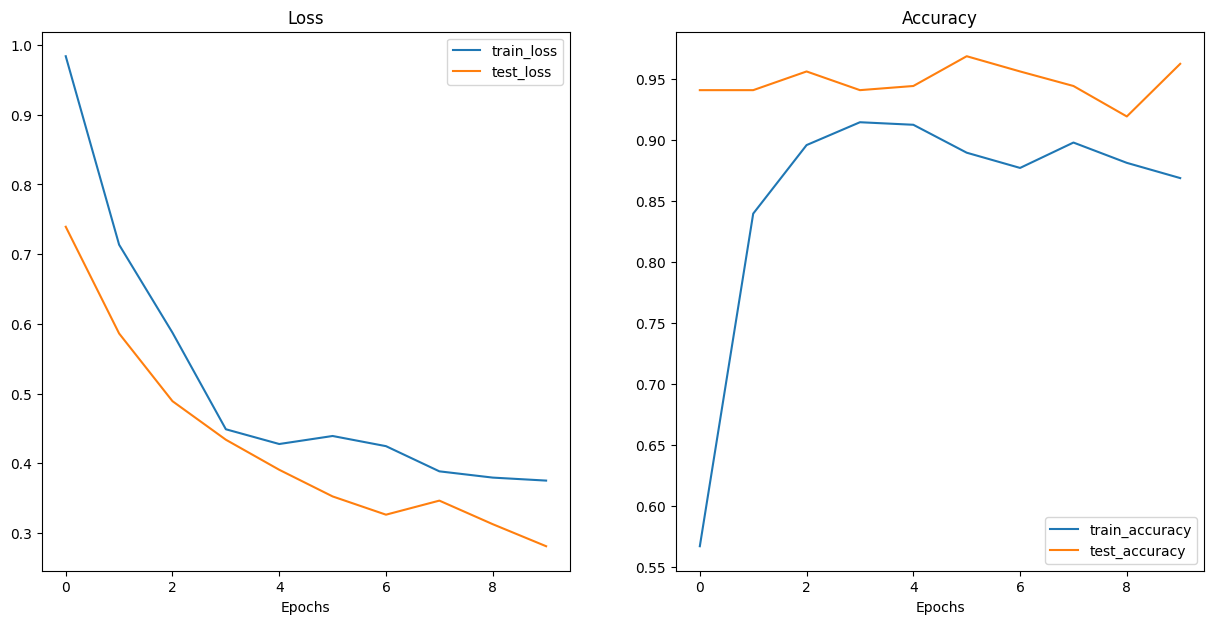

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### **3.5 Saving EffNetB2 feature extractor**

Now we've got a well-performing trained model, let's save it to file so we can import and use it later.

To save our model we can use the utils.save_model() function we created in 05. PyTorch Going Modular section 5.

We'll set the target_dir to "models" and the model_name to "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth" (a little comprehensive but at least we know what's going on).

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### **3.6 Checking the size of EffNetB2 feature extractor**

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### **3.7 Collecting EffNetB2 feature extractor stats**

We've got a few statistics about our EffNetB2 feature extractor model such as test loss, test accuracy and model size, how about we collect them all in a dictionary so we can compare them to the upcoming ViT feature extractor.

And we'll calculate an extra one for fun, total number of parameters.

We can do so by counting the number of elements (or patterns/weights) in effnetb2.parameters(). We'll access the number of elements in each parameter using the torch.numel() (short for "number of elements") method.

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## **4. Creating a ViT feature extractor**

Time to continue with our FoodVision Mini modelling experiments.

This time we're going to create a ViT feature extractor.

And we'll do it in much the same way as the EffNetB2 feature extractor except this time with `torchvision.models.vit_b_16()` instead of `torchvision.models.efficientnet_b2()`.

We'll start by creating a function called `create_vit_model()` which will be very similar to `create_effnetb2_model()` except of course returning a ViT feature extractor model and transforms rather than EffNetB2.

Another slight difference is that `torchvision.models.vit_b_16()`'s output layer is called heads rather than classifier.

In [ ]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 156MB/s]


In [ ]:
from torchinfo import summary

# Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### **4.1 Create DataLoaders for ViT**

We've got our ViT model ready, now let's create some `DataLoaders` for it.

We'll do this in the same way we did for EffNetB2 except we'll use `vit_transforms` to transform our images into the same format the ViT model was trained on.

In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

### **4.2 Training ViT feature extractor**

Let's train our ViT feature extractor model for 10 epochs using our `engine.train()` function with `torch.optim.Adam()` and a learning rate of `1e-3` as our optimizer and `torch.nn.CrossEntropyLoss()` as our loss function.

We'll use our `set_seeds()` function before training to try and make our results as reproducible as possible.

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### **4.3 Inspecting ViT loss curves**

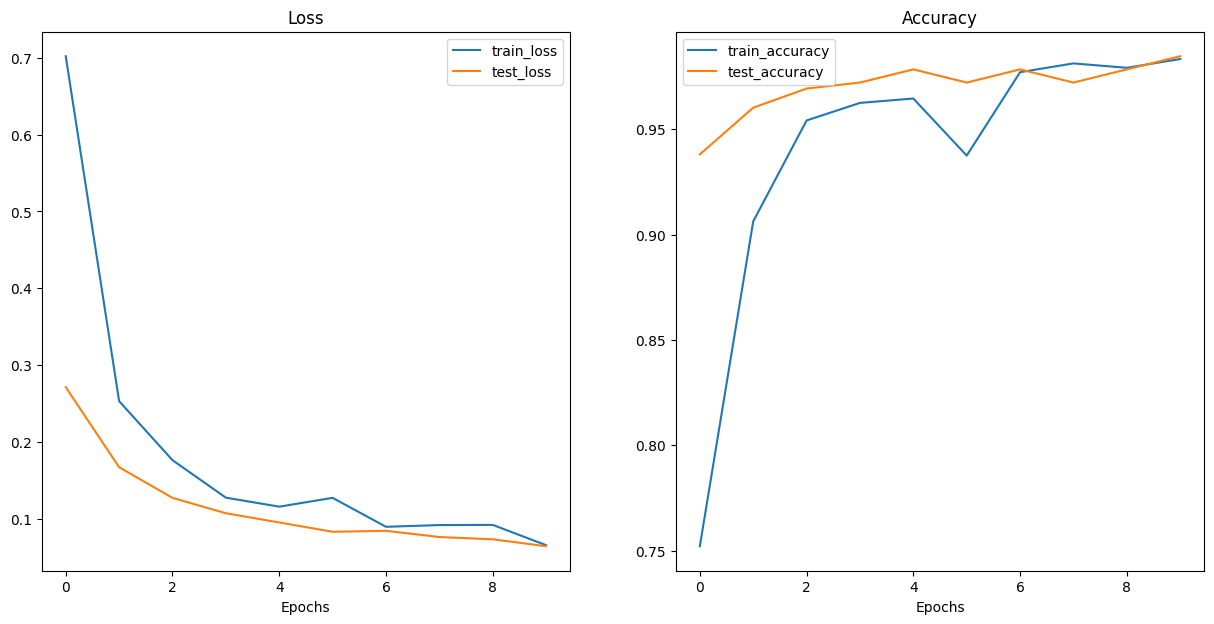

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### **4.4 Saving ViT feature extractor**

Our ViT model is performing outstanding!

So let's save it to file so we can import it and use it later if we wish.

We can do so using the `utils.save_model()` function we created in 05. PyTorch Going Modular section 5.

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### **4.5 Checking the size of ViT feature extractor**

To check our model's size in bytes, we can use Python's `pathlib.Path.stat("path_to_model")`.st_size and then we can convert it (roughly) to megabytes by dividing it by `(1024*1024)`.

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### **4.6 Collecting ViT feature extractor stats**

In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## **5. Making predictions with our trained models and timing them**

To find out how long each of our models take to performance inference, let's create a function called `pred_and_store()` to iterate over each of the test dataset images one by one and perform a prediction.

We'll time each of the predictions as well as store the results in a common prediction format: a list of dictionaries (where each element in the list is a single prediction and each sinlge prediction is a dictionary).

To do so, we'll use Python's `pathlib.Path("target_dir").glob("*/*.jpg")` to find all of the filepaths in a target directory with the extension `.jpg` (all of our test images).

In [ ]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/167716.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3886015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/128616.jpg')]

### **5.1 Creating a function to make predictions across the test dataset**

Now we've got a list of our test image paths, let's get to work on our `pred_and_store()` function:

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.
2. Create an empty list to store prediction dictionaries (we want the function to return a list of dictionaries, one for each prediction).
3. Loop through the target input paths and the rest of the steps will take place inside the loop. (steps 4-14 will happen inside the loop).
4. Create an empty dictionary for each iteration in the loop to store prediction values per sample.
5. Get the sample path and ground truth class name (we can do this by infering the class from the path).
6. Start the prediction timer using Python's `timeit.default_timer()`.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image so it's capable of being used with the target model as well as add a batch dimension and send the image to the target device.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and calculate the prediction probability using torch.softmax() and the target label using `torch.argmax()`.
11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.
13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries.

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

### **5.2 Making and timing predictions with EffNetB2**

Time to test out our `pred_and_store()` function!

Let's start by using it to make predictions across the test dataset with our EffNetB2 model, paying attention to two details:

1. **Device** - We'll hard code the `device` parameter to use `"cpu"` because when we deploy our model, we won't always have access to a `"cuda"` (GPU) device.
* Making the predictions on CPU will be a good indicator of speed of inference too because generally predictions on CPU devices are slower than GPU devices.

2. **Transforms** - We'll also be sure to set the `transform` parameter to `effnetb2_transforms` to make sure the images are opened and transformed in the same way our `effnetb2` model has been trained on.

In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.6069,
  'pred_class': 'sushi',
  'time_for_pred': 0.1848,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9171,
  'pred_class': 'sushi',
  'time_for_pred': 0.1108,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.6069,sushi,0.1848,True
1,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9171,sushi,0.1108,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.4836,sushi,0.1097,True
3,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9504,sushi,0.1182,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9492,sushi,0.1109,True


In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

**Note:** Prediction times will be different across different hardware types (e.g. a local Intel i9 vs Google Colab CPU). The better and faster the hardware, generally, the faster the prediction. For example, on my local deep learning PC with an Intel i9 chip, my average prediction time with EffNetB2 is around 0.031 seconds (just under real-time). However, on Google Colab (I'm not sure what CPU hardware Colab uses but it looks like it might be an Intel(R) Xeon(R)), my average prediction time with EffNetB2 is about 0.1396 seconds (3-4x slower).

In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1206 seconds


In [ ]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1206}

### **5.3 Making and timing predictions with ViT**

We've made predictions with our EffNetB2 model, now let's do the same for our ViT model.

To do so, we can use the `pred_and_store()` function we created above except this time we'll pass in our `vit` model as well as the `vit_transforms`.

And we'll keep the predictions on the CPU via `device="cpu"` (a natural extension here would be to test the prediction times on CPU and on GPU).

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9895,
  'pred_class': 'sushi',
  'time_for_pred': 0.7189,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9963,
  'pred_class': 'sushi',
  'time_for_pred': 0.5807,
  'correct': True}]

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9895,sushi,0.7189,True
1,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9963,sushi,0.5807,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.6123,sushi,0.5900,True
3,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9441,sushi,0.8471,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9876,sushi,0.9024,True


In [ ]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.6073 seconds


**Note:** The average time per prediction values will be highly dependent on the hardware you make them on. For example, for the ViT model, my average time per prediction (on the CPU) was 0.0693-0.0777 seconds on my local deep learning PC with an Intel i9 CPU. Where as on Google Colab, my average time per prediction with the ViT model was 0.6766-0.7113 seconds.

In [ ]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.6073}

## **6. Comparing model results, prediction times and size**

Our two best model contenders have been trained and evaluated.

Now let's put them head to head and compare across their different statistics.

To do so, let's turn our `effnetb2_stats` and `vit_stats` dictionaries into a pandas DataFrame.

We'll add a column to view the model names as well as convert the test accuracy to a whole percentage rather than decimal.

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29,0.1206,EffNetB2
1,0.064435,98.47,85800963,327,0.6073,ViT


Which model is better?
1. `test_loss` (lower is better) - ViT
2. `test_acc` (higher is better) - ViT
3. `number_of_parameters` (generally lower is better*) - EffNetB2 (if a model has more parameters, it generally takes longer to compute)
* *sometimes models with higher parameters can still perform fast
4. `model_size` (MB) - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
5. `time_per_pred_cpu` (lower is better, will be highly dependent on the hardware you're running on) - EffNetB2

Both models failed to achieve our goal of 30+FPS... however we could always just try and use EffNetB2 and see how it goes.

In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229233,1.023065,11.135432,11.275862,5.035655


### **6.1 Visualizing the speed vs. performance tradeoff**

**Note:** Performance or inference time is also often referred to as "latency".

We can visualize with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model size (`model_size (MB)`)

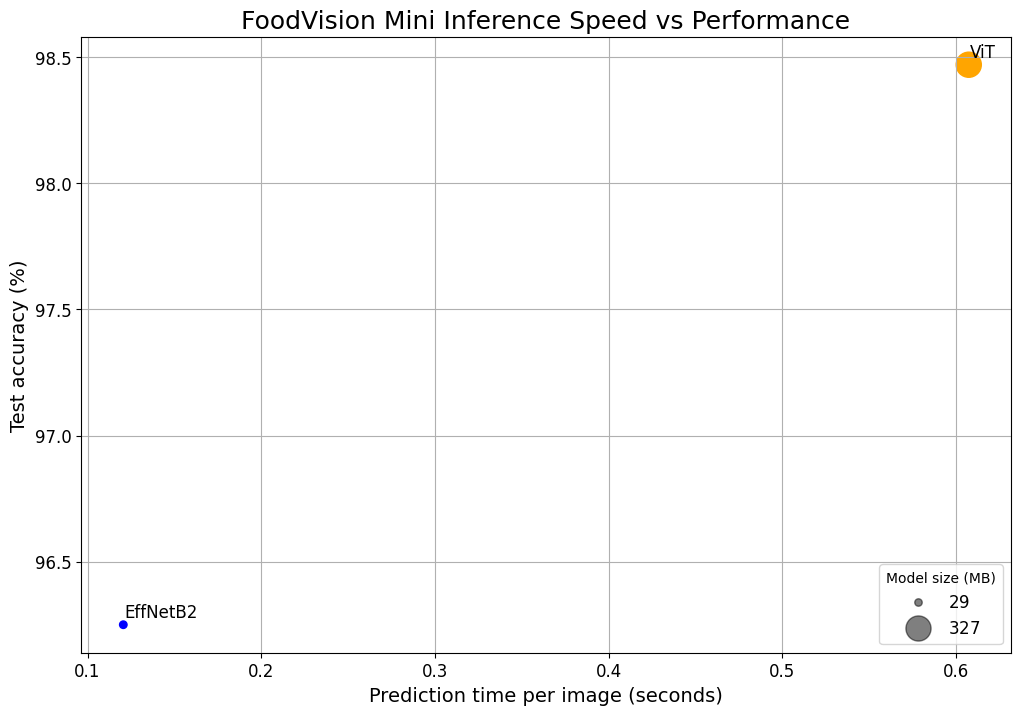

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## **7. Bringing FoodVision Mini to life by creating a Gradio demo**

We've decided we'd like to deploy the EffNetB2 model (to begin with, this could always be changed later).

So how can we do that?

There are several ways to deploy a machine learning model each with specific use cases (as discussed above).

We're going to be focused on perhaps the quickest and certainly one of the most fun ways to get a model deployed to the internet.

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━

### **7.1 Gradio overview**

Gradio helps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployment is as important as training.

The overall premise of Gradio to map inputs -> function/model -> outputs.

### **7.2 Creating a function to map our inputs and outputs.**

In [ ]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

`images of food -> ML Model (EffNetB2) -> outputs (food class label, prediciton time)

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_timer = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_timer = timer()
  pred_time = round(end_timer - start_timer, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time


In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_path = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

Example test data path: data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg
[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg

{'pizza': 0.0969151109457016, 'steak': 0.07548578083515167, 'sushi': 0.8275991082191467}
0.1038


### **7.3 Creating a list of example images**

In [ ]:
# Create a list of exmaple inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_path, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/128616.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/1848936.jpg']]

### **7.4 Building a Gradio Interface**

Let's use `gr.Interface()` to go from:

`input: image -> transform -> predict with EffNetB2 -> output: pred, prob prob time`

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ae7764f8925e0a40e5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## **8. Turning our FoodVision Mini Gradio Demo into a deployable app**

We've seen our FoodVision Mini model come to life through a Gradio demo.

But what if we wanted to share it with our friends?

Well, we could use the provided Gradio link, however, the shared link only lasts for 72-hours.

### **8.1 What is Hugging Face Spaces?**

Hugging Face Spaces is a resource that allows you to host and share machine learning apps.

Building a demo is one of the best ways to showcase and test what you've done.

And Spaces allows you to do just that.

You can think of Hugging Face as the GitHub of machine learning.

If having a good GitHub portfolio showcases your coding abilities, having a good Hugging Face portfolio can showcase your machine learning abilities.

**Note:** There are many other places we could upload and host our Gradio app such as, Google Cloud, AWS (Amazon Web Services) or other cloud vendors, however, we're going to use Hugging Face Spaces due to the ease of use and wide adoption by the machine learning community.

### **8.2 Deployed Gradio app structure**
To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path demos/foodvision_mini/ with the file structure:

demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
Where:

* `09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth` is our trained PyTorch model file.

* `app.py` contains our Gradio app (similar to the code that launched the app).

  * **Note:** `app.py` is the default filename used for Hugging Face Spaces, if you deploy your app there, Spaces will by default look for a file called `app.py` to run. This is changable in settings.

* `examples/` contains example images to use with our Gradio app.

* `model.py` contains the model defintion as well as any transforms assosciated with the model.

* `requirements.txt` contains the dependencies to run our app such as `torch`, torchvision and gradio.

Why this way?

Because it's one of the simplest layouts we could begin with.

Our focus is: experiment, experiment, experiment!

The quicker we can run smaller experiments, the better our bigger ones will be.

### **8.3 Creating a `demos` folder to store our FoodVision Mini app files**

To begin, let's first create a `demos/` directory to store all of our FoodVision Mini app files.

We can do with Python's `pathlib.Path("path_to_dir")` to establish the directory path and `pathlib.Path("path_to_dir").mkdir()` to create it.

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, # make the parent folders
                                    exist_ok=True) # create it even if it already exists
else:
    # If the file doesn't exist, create it anyway
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/foodvision_mini/

### **8.4 Creating a folder of example images to use with our FoodVision Mini demo**

Now we've got a directory to store our FoodVision Mini demo files, let's add some examples to it.

Three example images from the test dataset should be enough.

To do so we'll:

Create an `examples/` directory within the `demos/foodvision_mini directory`.
Choose three random images from the test dataset and collect their filepaths in a list.
Copy the three random images from the test dataset to the `demos/foodvision_mini/examples/` directory.

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

Let's now verify that we can get a list of lists from our `examples/` directory.

In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

### **8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory**

We previously saved our FoodVision Mini EffNetB2 feature extractor model under `models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth.`

And rather double up on saved model files, let's move our model to our `demos/`foodvision_mini directory.

We can do so using Python's `shutil.move()` method and passing in `src` (the source path of the target file) and `dst` (the destination path of the target file to be moved to) parameters.

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

### **8.6 Turning off EffNetB2 model into a Python script (model.py)**

We have a saved `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script so we can use it.

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

### **8.7 Turning our FoodVision Mini Gradio app into a Python script `(app.py)`**

The `app.py` file will have four major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + launch command

In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

### **8.8 Creating a requirements file for FoodVision Mini `requirements.txt`**

The requirements file will tell our Hugging Face Space what software dependencies our app requires.

* `torch`
* `torchvision`
* `gradio`

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

## **9. Deploying our FoodVision Mini app to HuggingFace Spaces**

We've got a file containing our FoodVision Mini demo, now how do we get it to run on Hugging Face Spaces?

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

* Uploading via the Hugging Face Web interface (easiest).
* Uploading via the command line or terminal.
  * Bonus: You can also use the huggingface_hub library to interact with Hugging Face, this would be a good extension to the above two options.

### **9.1 Downloading our FoodVision Mini app files**

Let's check out the demo files we've got inside `demos/foodvision_mini`.

To do so we can use the `!ls` command followed by the target filepath.

`ls` stands for "list" and the `!` means we want to execute the command at the shell level.

In [ ]:
!ls demos/foodvision_mini

Where:

`zip` stands for "zip" as in "please zip together the files in the following directory".

`-r` stands for "recursive" as in, "go through all of the files in the target directory".

`../foodvision_mini.zip` is the target directory we'd like our files to be zipped to.

`*` stands for "all the files in the current directory".

`-x` stands for "exclude these files".

In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")